# Prediction of Volcanic Eruptions

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.cluster import KMeans, MeanShift, DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import math
import statsmodels.formula.api as sm
import statistics
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv('data.csv')
data = data.drop(['Unnamed: 0'],axis = 1)
data.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt
0,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790,20128938
1,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,1.104332,-6.360564,9598270
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,31206935
3,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,5.498189,10.939634,35659379
4,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394,15695097


In [4]:
#summary of the dataset
data.describe()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt
count,4407.000000,3596.000000,3996.000000,4431.000000,3836.000000,4431.000000,4389.000000,3991.000000,4307.000000,4407.000000,4.431000e+03
mean,-0.527495,1.428776,-0.238219,-0.115163,3.721506,0.141111,-0.154080,-0.003951,-0.088121,-0.364520,2.284891e+07
std,17.960217,79.477000,94.819688,19.995443,89.710167,23.889173,20.212301,24.411388,20.776701,34.661692,1.348439e+07
min,-595.472192,-245.220530,-955.849657,-454.931201,-361.472525,-671.226330,-787.281279,-969.257812,-419.880502,-1219.251543,6.250000e+03
25%,-1.794853,-1.946793,-2.115156,-1.640873,-0.644756,-2.945343,-2.348461,-2.126440,-1.455901,-3.348611,1.127016e+07
50%,0.028150,-0.037983,-0.138623,-0.017033,-0.030358,0.030599,0.164781,0.039483,0.040475,0.125598,2.246559e+07
75%,1.840611,1.931755,1.652031,1.641714,0.623260,2.906927,2.219630,2.299087,1.526947,3.866427,3.434356e+07
max,341.221530,4489.707085,5686.462355,649.010650,3396.214387,849.034149,339.217580,734.346294,752.144481,1022.320278,4.904609e+07


In [5]:
#Dimension of the dataset
data.shape

(4431, 11)

In [6]:
#Checking for null values
total = data.isnull().sum().sort_values(ascending=False)
total

sensor_2       835
sensor_5       595
sensor_8       440
sensor_3       435
sensor_9       124
sensor_7        42
sensor_10       24
sensor_1        24
timetoerupt      0
sensor_6         0
sensor_4         0
dtype: int64

## Feature Engineering

### 1.Handling missing data

,sensor_2,sensor_5,sensor_8,sensor_3,sensor_9,sensor_7,sensor_10,sensor_1,timetoerupt,sensor_6,sensor_4
Total,835.000000,595.000000,440.000000,435.000000,124.000000,42.000000,24.000000,24.000000,0.000000,0.000000,0.000000
Percent,0.188445,0.134281,0.099300,0.098172,0.027985,0.009479,0.005416,0.005416,0.000000,0.000000,0.000000


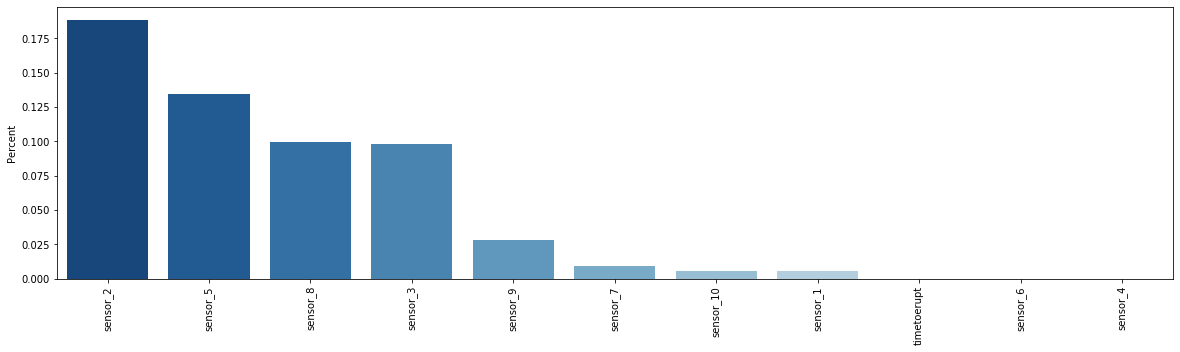

In [7]:
#find the percentage of missing data in all columns
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


#plot the graph for the percentage of missing data in all columns
fig, ax = plt.subplots(figsize=(20, 5))
sns.barplot(x=missing_data.index, y='Percent', data=missing_data, palette='Blues_r')
plt.xticks(rotation=90)

display(missing_data.T.style.background_gradient(cmap='Blues', axis=1))

In [8]:
#filling the missing values with the mean value
data.fillna(data.mean(), inplace=True)
data.isnull().sum().sort_values(ascending=False)

timetoerupt    0
sensor_10      0
sensor_9       0
sensor_8       0
sensor_7       0
sensor_6       0
sensor_5       0
sensor_4       0
sensor_3       0
sensor_2       0
sensor_1       0
dtype: int64

### 2. Handling Outliers

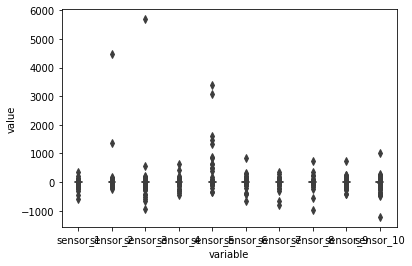

In [9]:
#Finding outliers for each column using boxplot

df = pd.DataFrame(data = data, columns = ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6',
                                         'sensor_7','sensor_8','sensor_9','sensor_10'])

sns.boxplot(x="variable", y="value", width= 0.2, data=pd.melt(df))

plt.show()


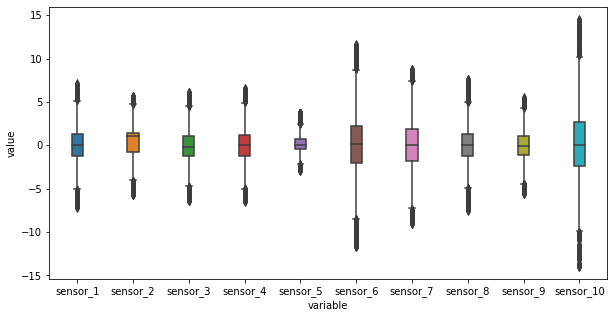

In [10]:
#Removing outliers using IQR score and plotting box-plot

Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

data = data[~((data < (Q1 - 1.5 * IQR)) |(data > (Q3 + 1.5 * IQR))).any(axis=1)]
data.shape

df = pd.DataFrame(data = data, columns = ['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6',
                                         'sensor_7','sensor_8','sensor_9','sensor_10'])
plt.figure(figsize=(10,5))
sns.boxplot(x="variable", y="value", width= 0.2, data=pd.melt(df))

plt.show()

### 3. Log Transform

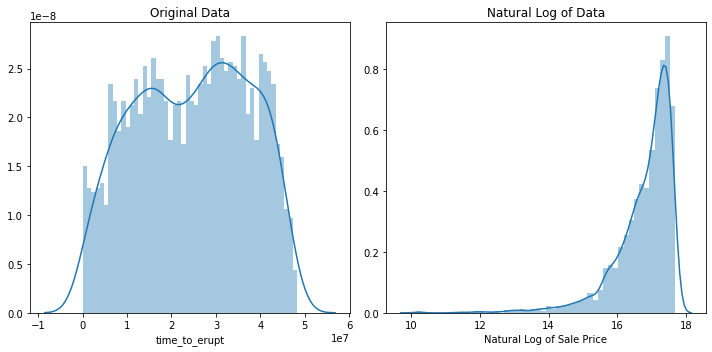

In [11]:
#remove the skewness of the target variable
target = data[data.columns.values[-1]]
target_log = np.log(target)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.distplot(target, bins=50)
plt.title('Original Data')
plt.xlabel('time_to_erupt')

plt.subplot(1,2,2)
sns.distplot(target_log, bins=50)
plt.title('Natural Log of Data')
plt.xlabel('Natural Log of Sale Price')
plt.tight_layout()

In [12]:
data['timetoerupt'] = (data['timetoerupt']+1).transform(np.log)
data.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt
1,0.905818,1.428776,-0.648256,-2.339661,0.320345,6.707488,-3.654656,-0.003951,1.104332,-6.360564,16.077094
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,17.256151
5,1.490842,1.428776,3.403243,1.166847,0.057932,4.377694,0.649256,-0.003951,-0.931768,3.747471,17.393408
9,0.611856,1.428776,0.503875,1.618940,-0.399443,-1.121048,-0.176997,-0.003951,-0.233863,1.398910,17.502188
11,3.639473,1.091048,-1.070315,-2.159197,1.402977,1.295945,-1.982684,-0.878985,1.696733,-5.347544,17.543255


### 4. Standard Scaling

In [13]:
# create a scaler object
scaler = MinMaxScaler()

# fit and transform the data
df_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

df_norm.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt
0,0.562137,0.625191,0.461888,0.321727,0.492680,0.789079,0.303147,0.495679,0.601081,0.267348,0.785709
1,0.597945,0.539330,0.418217,0.615313,0.368551,0.435740,0.610455,0.604450,0.400748,0.436263,0.942151
2,0.602800,0.625191,0.783838,0.589110,0.453645,0.689162,0.543067,0.495679,0.420077,0.622302,0.960363
3,0.541705,0.625191,0.553442,0.623584,0.385608,0.453339,0.497007,0.495679,0.482119,0.539830,0.974796
4,0.752143,0.595658,0.428349,0.335488,0.653727,0.556995,0.396350,0.438040,0.653744,0.302921,0.980245


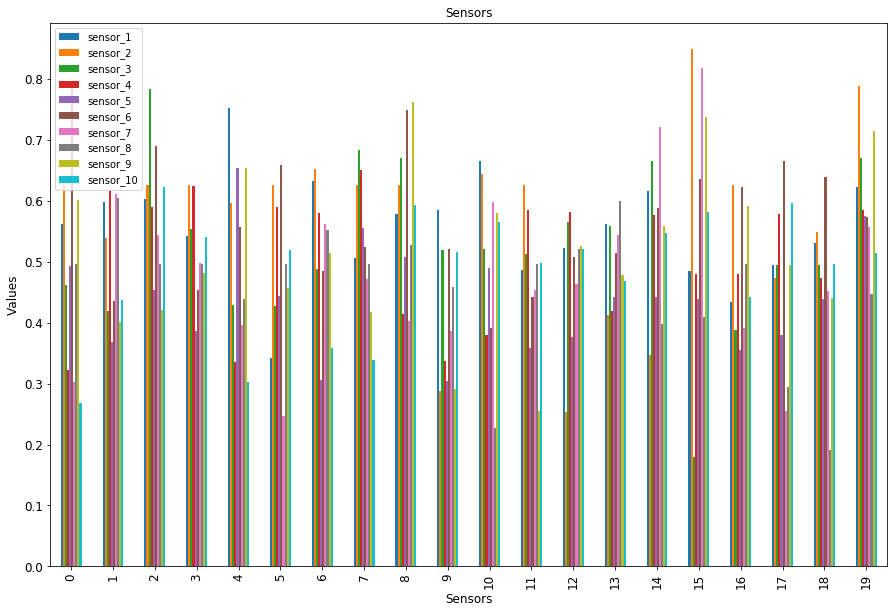

In [14]:
df_ax = df_norm.head(20)
ax = df_ax[['sensor_1','sensor_2','sensor_3','sensor_4','sensor_5','sensor_6',
              'sensor_7','sensor_8','sensor_9','sensor_10']].plot(kind='bar', title ="Sensors", figsize=(15, 10), legend=True, fontsize=12)
ax.set_xlabel("Sensors", fontsize=12)
ax.set_ylabel("Values", fontsize=12)
plt.show()

### 5. Creating new Features

### 1. log value

In [15]:
#Finding the log values of the dependent variable

data_feature = pd.read_csv('data.csv')
data_feature = data_feature.drop(['Unnamed: 0'],axis = 1)
data_feature['log(x+1)'] = (df_norm['timetoerupt']+1).transform(np.log)
data_feature.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt,log(x+1)
0,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790,20128938,0.579815
1,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,1.104332,-6.360564,9598270,0.663796
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,31206935,0.673130
3,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,5.498189,10.939634,35659379,0.680465
4,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394,15695097,0.683221


### 2. Z-score

In [16]:
#Finding the z-score value of the dependent variable

data_feature['zscore']=StandardScaler().fit_transform(data_feature.loc[: ,['timetoerupt']].values)
data_feature.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt,log(x+1),zscore
0,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790,20128938,0.579815,-0.201735
1,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,1.104332,-6.360564,9598270,0.663796,-0.982776
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,31206935,0.673130,0.619900
3,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,5.498189,10.939634,35659379,0.680465,0.950130
4,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394,15695097,0.683221,-0.530585


### 3. Savitzky–Golay filter and Simple Moving Average 

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt,log(x+1),zscore,Close_SG,Close_SMA
0,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790,20128938,0.579815,-0.201735,1.403344e+07,NaN
1,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,1.104332,-6.360564,9598270,0.663796,-0.982776,2.110914e+07,NaN
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,31206935,0.673130,0.619900,2.621124e+07,NaN
3,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,5.498189,10.939634,35659379,0.680465,0.950130,2.956280e+07,NaN
4,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394,15695097,0.683221,-0.530585,3.138450e+07,NaN


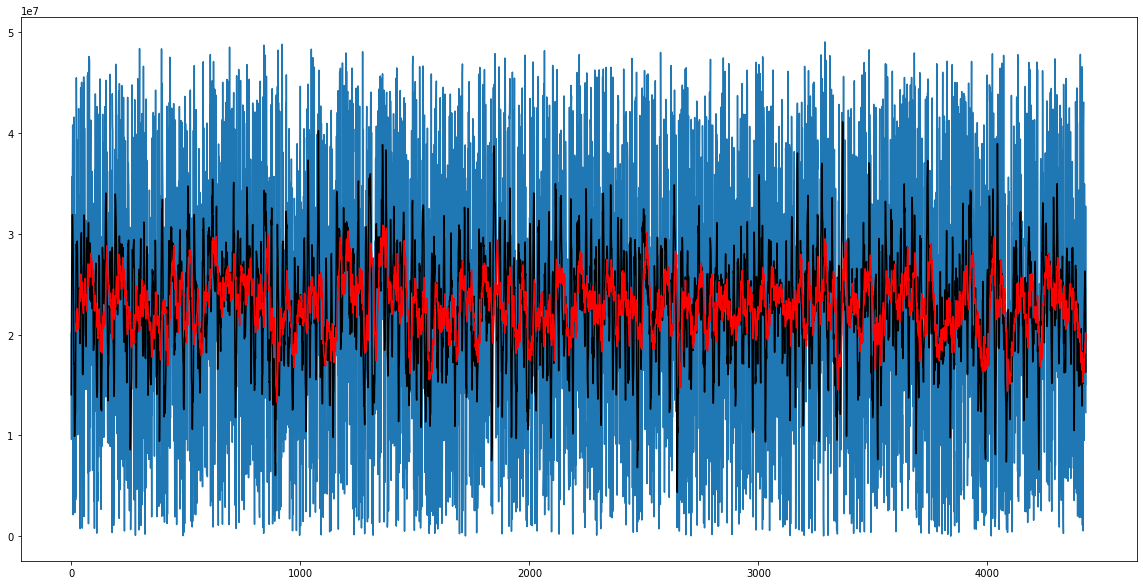

In [17]:
#Handling noisy data

#Savitzky–Golay filter and Simple Moving Average 

plt.rcParams["figure.figsize"] = [20, 10]


data_feature['Close_SG']=savgol_filter(data_feature['timetoerupt'], 21, 4)
data_feature['Close_SMA']=data_feature['timetoerupt'].rolling(window=21).mean()

ax=data_feature['timetoerupt'].plot()
data_feature.Close_SG.plot(ax=ax, color='black')
data_feature.Close_SMA.plot(ax=ax, color='red')

data_feature.head()

### 4. Binning

In [18]:
#Finding bins for the eruption data

data_feature['timetoerupt'] = (data_feature['timetoerupt']+1).transform(np.log)


data_feature['timetoerupt_bins'] = pd.cut(x=data_feature['timetoerupt'], bins=[5,10,15,20])
data_feature.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8,sensor_9,sensor_10,timetoerupt,log(x+1),zscore,Close_SG,Close_SMA,timetoerupt_bins
0,-4.142848,0.138031,1.955217,0.241129,-1.577340,0.385694,1.526325,0.802537,-1.700145,-45.584790,16.817669,0.579815,-0.201735,1.403344e+07,NaN,"(15, 20]"
1,0.905818,NaN,-0.648256,-2.339661,0.320345,6.707488,-3.654656,NaN,1.104332,-6.360564,16.077094,0.663796,-0.982776,2.110914e+07,NaN,"(15, 20]"
2,1.420993,0.446893,-1.197830,1.510475,-0.514108,-1.531391,1.858136,1.647323,-1.149198,-1.550374,17.256151,0.673130,0.619900,2.621124e+07,NaN,"(15, 20]"
3,7.936884,NaN,5.014233,-4.597357,NaN,0.607590,1.506825,-4.511225,5.498189,10.939634,17.389523,0.680465,0.950130,2.956280e+07,NaN,"(15, 20]"
4,0.906735,-3.658256,-0.751437,1.915551,-1.734333,-22.033699,1.607623,0.046333,-1.802253,-3.377394,16.568859,0.683221,-0.530585,3.138450e+07,NaN,"(15, 20]"


## Dimensionality Reduction

### 1. Variance check

In [19]:
#Variance check

df_norm.var()

sensor_1       0.024235
sensor_2       0.031443
sensor_3       0.028372
sensor_4       0.026432
sensor_5       0.036917
sensor_6       0.029945
sensor_7       0.029095
sensor_8       0.027529
sensor_9       0.028131
sensor_10      0.026387
timetoerupt    0.013321
dtype: float64

### 2. Correlation Check

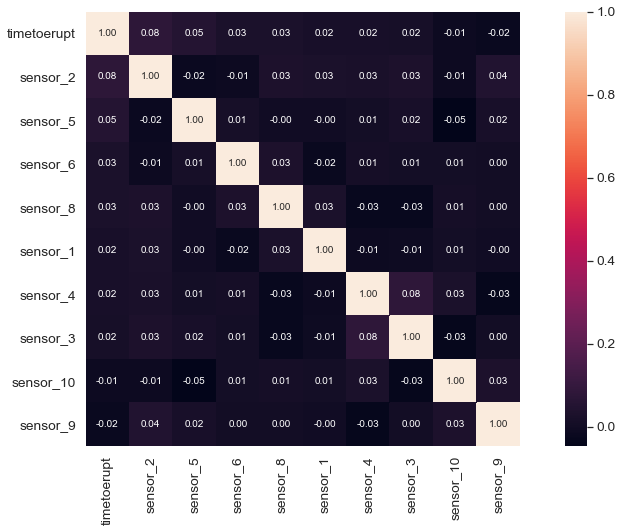

In [20]:
#timetoerupt correlation heatmap for all the columns
k = 10 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = df_norm.corr()
# picking the top 15 correlated features
cols = corrmat.nlargest(k, 'timetoerupt')['timetoerupt'].index
cm = np.corrcoef(df_norm[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Since there is no much correlation between the independent variables we are not dropping the variables.

### 3. Feature Importance

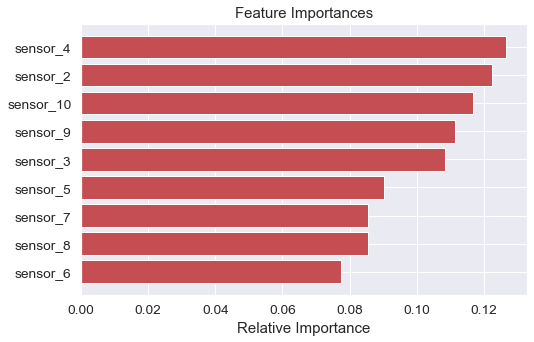

In [21]:
df=df_norm.drop('timetoerupt', 1)
plt.figure(figsize=(8,5))

model = RandomForestRegressor(random_state=1, max_depth=10)
df=pd.get_dummies(df)
model.fit(df,df_norm.timetoerupt)

model.feature_importances_

features = df.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-9:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## Unsupervised learning models

### 1. Partitioning Clustering - KMeans & Meanshift

### 1.1 Kmeans

In [22]:
# Get column names first
names = df_norm.columns

#Create the Scalar Object
scaler = preprocessing.StandardScaler()

# Fit your data on the scalar object
scaled_df = scaler.fit_transform(df_norm)
scaled_df = pd.DataFrame(df_norm,columns = names)

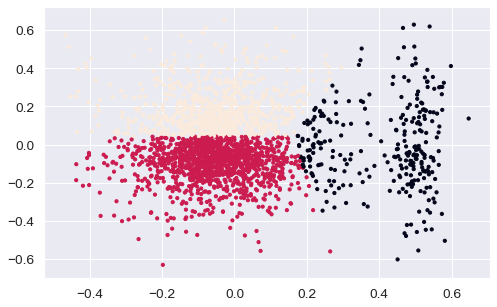

In [23]:
pca = PCA(n_components = 2)
principalComponents = pca.fit_transform(scaled_df)
principalDf = pd.DataFrame(data = principalComponents
, columns = ['principal component 1', 'principal component 2'])

plt.figure(figsize=(8,5))
kmeans = KMeans(n_clusters=3)
kmeans.fit(principalDf)
labels = kmeans.predict(principalDf)

plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1],s=10, c=kmeans.predict(principalDf))

### 1.2 Meanshift

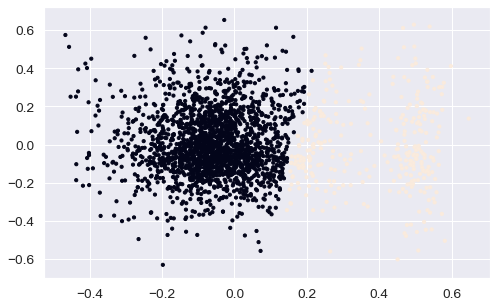

In [24]:
ms = MeanShift()
plt.figure(figsize=(8,5))
ms.fit(principalDf)
plt.scatter(principalDf.iloc[:,0], principalDf.iloc[:,1],s=10, c=ms.predict(principalDf))

## 2. Hierarchial Clustering - Agglomerative

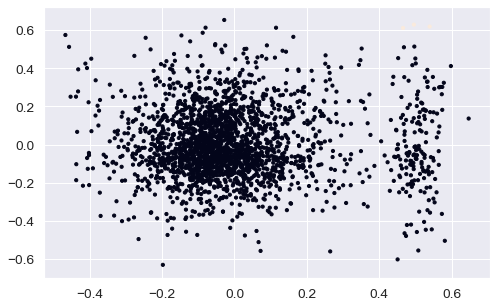

In [25]:
agc = AgglomerativeClustering(linkage='average')
agc.fit(principalDf)
plt.figure(figsize=(8,5))
plt.scatter(principalDf.iloc[:,0],
principalDf.iloc[:,1],
s=10,
c=agc.labels_)

## 3. Density Based Clustering - DBSCAN

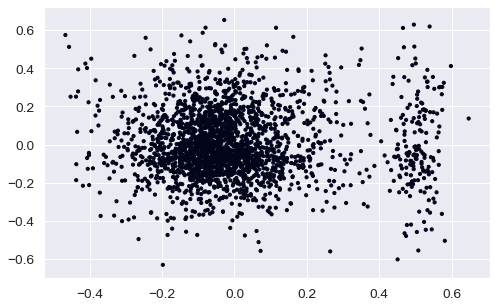

In [26]:
db = DBSCAN(eps=0.3, min_samples=10).fit(principalDf)
labels = db.labels_
plt.figure(figsize=(8,5))
plt.scatter(principalDf.iloc[:,0],
principalDf.iloc[:,1],
s=10,
c=db.labels_)

## Supervised learning models

### 1. Decision Tree Regression Model:

In [27]:
## From train divide into 70% 30% train and test respectively

X_train, X_test, y_train, y_test = train_test_split(df_norm.drop('timetoerupt', axis=1), df_norm['timetoerupt'], 
                                                    test_size=0.3, random_state=101)

In [29]:
#instantiate model
tree_reg = DecisionTreeRegressor(random_state = 100)
#fit the model
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=100, splitter='best')

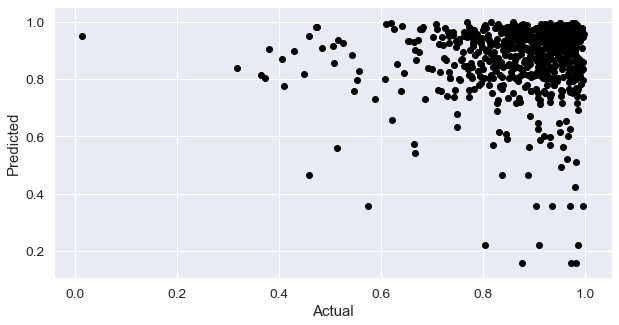

In [30]:
#Predict on new data
tree_pred = tree_reg.predict(X_test)
tree_pred= tree_pred.reshape(-1,1)
#plot the actual and predicted scatter plot
plt.figure(figsize=(10,5))
plt.scatter(y_test,tree_pred, color = 'black')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [31]:
#Evalutaion of the metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, tree_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, tree_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, tree_pred)))
print('R-squared Error:', metrics.r2_score(y_test, tree_pred))

Mean Absolute Error: 0.11005558475357353
Mean Squared Error: 0.027850985043402464
Root Mean Squared Error: 0.16688614395270346
R-squared Error: -1.0307030037909515


### 2. Support Vector Regression Model

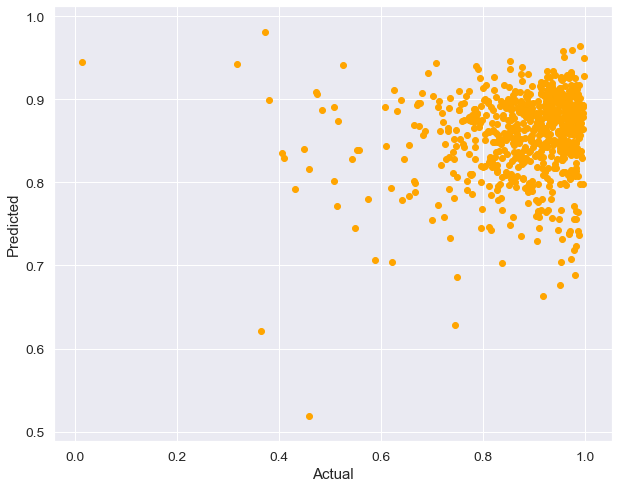

In [32]:
##instantiate model
svmr = SVR(kernel = 'rbf')

#fit the model
svmr.fit(X_train, y_train)

#predict on new data
svmr_pred = svmr.predict(X_test)
svmr_pred= svmr_pred.reshape(-1,1)

plt.figure(figsize=(10,8))
plt.scatter(y_test,svmr_pred, c='orange')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [33]:
#Evalutaion of the metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, svmr_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, svmr_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, svmr_pred)))
print('R-squared Error:', metrics.r2_score(y_test, svmr_pred))

Mean Absolute Error: 0.0898734937539178
Mean Squared Error: 0.015275259279994163
Root Mean Squared Error: 0.12359311987321205
R-squared Error: -0.11376724576274433


### 3. Linear Regression Model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
0.8289772956525667
[ 0.02772072  0.0429204   0.00910484 -0.00659063  0.03887135  0.03999554
 -0.04512947  0.01696656 -0.01538872 -0.00813858]


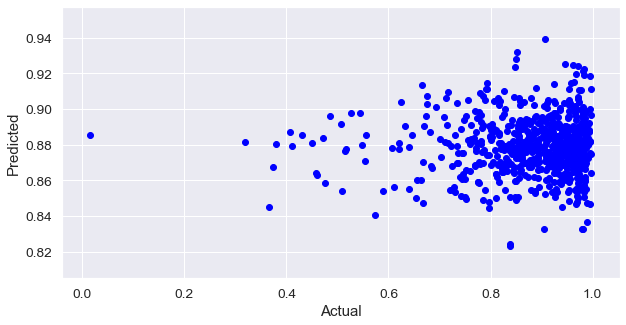

In [34]:
#instantiate model
regressor = LinearRegression()

#fit the model to data
regressor.fit(X_train,y_train)

print(regressor)

#To retrieve the intercept:
print(regressor.intercept_)
#For retrieving the slope:
print(regressor.coef_)

#predict on new data
predictions = regressor.predict(X_test)
predictions= predictions.reshape(-1,1)

#plot the actual and predicted scatter plot
plt.figure(figsize=(10,5))
plt.scatter(y_test,predictions, color = 'blue')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

In [35]:
#Evalutaion of the metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R-squared Error:', metrics.r2_score(y_test, predictions))

Mean Absolute Error: 0.08309429434193914
Mean Squared Error: 0.013823004176499953
Root Mean Squared Error: 0.11757127275189273
R-squared Error: -0.00787875397903881


## Advanced model

### XGBoost

In [36]:
X, y = df_norm.iloc[:,:-1],df_norm.iloc[:,-1]

data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.175282


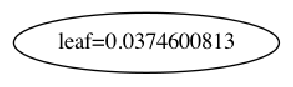

In [37]:
plt.rcParams['figure.figsize'] = [5, 5]
xgb.plot_tree(xg_reg,num_trees=0)

plt.show()

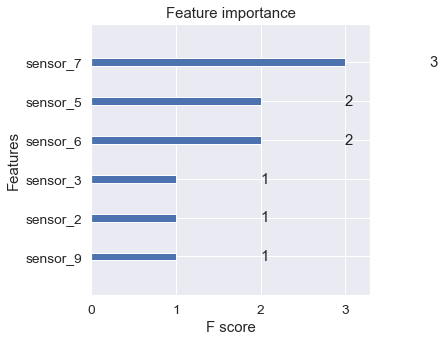

In [38]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()